# Web Scrape and SQL upload

In [1]:
# Import Necessary libraries
import r6tab_API_functions as r6
import pandas as pd
import sqlalchemy
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Scrape leaderboard info from function calls using r6tab API
NA_leaderboard_info = r6.get_leaderboard_info('p_NA_currentmmr')
EU_leaderboard_info = r6.get_leaderboard_info('p_EU_currentmmr')
AS_leaderboard_info = r6.get_leaderboard_info('p_AS_currentmmr')

# Let's take a look at the top player's info in NA
if NA_leaderboard_info is not None:
    print("Here's a preview: ")
    preview = NA_leaderboard_info[0]
    for k, v in preview.items():
        print("{0}: {1}".format(k, v))

Here's a preview: 
position: 1
p_id: f9eeea28-4c13-48df-b96a-49c726bf546c
p_name: One.TT
p_level: 158
p_platform: uplay
p_user: f9eeea28-4c13-48df-b96a-49c726bf546c
p_currentmmr: 6539
p_currentrank: 20
p_skillrating: 10602
p_NA_rank: 20
p_EU_rank: 20
p_AS_rank: 14
kd: 251
verified: 0
p_headshotacc: 64590000
p_NA_currentmmr: 6539


In [14]:
# Store leader boards into pandas data frames to easily upload to mysql server

NA = pd.DataFrame(NA_leaderboard_info)
EU = pd.DataFrame(EU_leaderboard_info)
AS = pd.DataFrame(AS_leaderboard_info)

# Let's see how one data frame looks like (first 6 columns, the dataframe is too wide for JPnotebooks)
print(NA.iloc[:5, :6])

    kd p_AS_rank p_EU_rank p_NA_currentmmr p_NA_rank p_currentmmr
0  251        14        20            6539        20         6539
1  166        20         0            6486        20         6486
2  187        20        20            6419        20         6419
3  157         0         0            6036        20         6036
4  262         0         0            6025        20         6025


*Now I want to store my data into a SQL database. This will make data manipulation a bit easier later when working with all three leader boards.*

In [15]:
# Log in information for mysql server
user = 'root'
passw = 'pw'
host = 'localhost'
database = 'r6_leaderboard_database'

# Establish a connection to the mysql server
engine_stmt = 'mysql+mysqlconnector://%s:%s@%s:3306/%s' % (user, passw, host, database)

engine = sqlalchemy.create_engine(engine_stmt)

In [22]:
# Work the magic

NA.to_sql(name='na_leaderboard', con=engine,
          if_exists='replace', index=False, chunksize=1000)
EU.to_sql(name='eu_leaderboard', con=engine,
          if_exists='replace', index=False, chunksize=1000)
AS.to_sql(name='as_leaderboard', con=engine,
          if_exists='replace', index=False, chunksize=1000)

test_df = pd.read_sql("SELECT * FROM eu_leaderboard", engine)

print(test_df.iloc[:5, :6])

print('it WORKED.')

    kd p_AS_rank p_EU_currentmmr p_EU_rank p_NA_rank p_currentmmr
0  175         0           10071        20         0        10071
1  144         0            8089        20         0         8089
2  185         0            7542        20         0         7542
3  227        14            7134        20         0         7134
4  179        18            6392        20         0         6392
it WORKED.


# Data Screening

**We want to increase our sample size, so we'd want to combine all three leaderboards into one. This will be a functioning global leaderboard of the top 300 players.**

## Issue #1
*The different leader board tables contain the same amount of columns and data types. BUT they are in a different order.*

*To use SQL UNION, they must be in the same order.*

*Rearrange columns to be uniform across all tables before combining.*

*Each region's leader board has a separately labeled p_REGION_currentmmr field. In the rainbow six database, this is actually a
global mmr. Also, in each region's leaderboard:*

- **p_REGION_currentmmr == p_currentmmr.**

*So to solve this issue, delete each leader board table's p_REGION_currentmmr*

In [32]:
# Let's check what's up with these two columns
with engine.connect() as con:
    try:
        check_dup = con.execute('select p_EU_currentmmr, p_currentmmr from r6_leaderboard_database.eu_leaderboard LIMIT 10')
        print(check_dup.keys())
        
        for row in check_dup:
            print(row)
    except:
        print('Already deleted the problem column...')

    con.close()


['p_EU_currentmmr', 'p_currentmmr']
('10071', '10071')
('8089', '8089')
('7542', '7542')
('7134', '7134')
('6392', '6392')
('6332', '6332')
('6288', '6288')
('6274', '6274')
('6239', '6239')
('6185', '6185')


In [33]:
# Delete the p_REGION_currentmmr columns from each table

# Do a test run first..
with engine.connect() as con:
    try:
        sql_delete_query = """ALTER TABLE %s DROP COLUMN %s"""
        con.execute(sql_delete_query % ('r6_leaderboard_database.na_test', 'p_NA_currentmmr'))
        
        print('delete done')
    except:
        print("Already Deleted")
        
    con.close()



Already Deleted


In [34]:
# Alright. Luckily, once we delete each p_REGION_mmr column from each table, the order and format of each table will be the same
with engine.connect() as con:
    try:
        sql_delete_query = """ALTER TABLE %s DROP COLUMN %s"""
        con.execute(sql_delete_query % ('r6_leaderboard_database.na_leaderboard', 'p_NA_currentmmr'))
        con.execute(sql_delete_query % ('r6_leaderboard_database.eu_leaderboard', 'p_EU_currentmmr'))
        con.execute(sql_delete_query % ('r6_leaderboard_database.as_leaderboard', 'p_AS_currentmmr'))

        print('delete done')
    except:
        print("Already Deleted")

    con.close()

delete done


In [35]:
# Now we're ready for a SQL UNION statement

with engine.connect() as con:

    union_query = """SELECT * FROM %s UNION SELECT * FROM %s UNION SELECT * FROM %s"""

    union = con.execute(union_query % ('r6_leaderboard_database.na_leaderboard',
                                      'r6_leaderboard_database.eu_leaderboard',
                                      'r6_leaderboard_database.as_leaderboard'))
    
    # Let's create a new table in the mysql server for this query since it will be our master dataset
    df = pd.DataFrame(union.fetchall())
    df.columns = union.keys()
    
    df.to_sql(name='all_leaderboard', con=engine,
          if_exists='replace', index=False, chunksize=1000)
    
    con.close()
    
    
print('Good to go.')
    

Good to go.


In [36]:
# Now we got our master dataset!

print(df)

      kd p_AS_rank p_EU_rank p_NA_rank p_currentmmr p_currentrank  \
0    251        14        20        20         6539            20   
1    166        20         0        20         6486            20   
2    187        20        20        20         6419            20   
3    157         0         0        20         6036            20   
4    262         0         0        20         6025            20   
5    159        20         0        20         6013            20   
6    160         0        16        20         5921            20   
7    161         0         0        20         5871            20   
8    144         0         0        20         5841            20   
9    119        19         0        20         5749            20   
10   174         0        19        20         5737            20   
11   181         0         0        20         5732            20   
12   106         0         3        20         5718            20   
13   154         0         0      

## Issue #2

**Further Data cleansing is required. The datatypes of the columns are all in TEXT. We need to change some into numeric
data types to be able to run analysis on them.**

For example, the kd column is actually a ratio column.

- *Player One.TT has a kd of 251, which should be 2.51. So we need to do this calculation (kd / 100)*

Similar situation for p_headshotaccuracy...

- *One.TT has a hs accuracy of 64,590,000. This should be a percentage (64.59%): (p_headshotacc / 1,000,000)*

Other columns such as p_currentmmr should simply be an integer column.


In [75]:
# Example of issue #2:

query = """SELECT p_name, kd, p_headshotacc FROM r6_leaderboard_database.all_leaderboard"""
df = pd.read_sql(query, con=engine)

print(df.head(1))

   p_name   kd p_headshotacc
0  One.TT  251      64590000


In [39]:
# This can all be fixed with a SQL query.
with engine.connect() as con:

    aggregate_query = """
                      SELECT p_name,
                             cast(kd / 100 as decimal(10,2)) as kd_ratio, 
                             cast(p_headshotacc / 1000000 as decimal(10,2)) as p_headshotacc,
                             cast(p_currentmmr as UNSIGNED) as p_currentmmr,
                             cast(p_level as UNSIGNED) as p_level,
                             cast(p_skillrating as UNSIGNED) as p_skillrating
                        FROM all_leaderboard
                      """

    aggregate_exec = con.execute(aggregate_query)

    # Store the aggregated data into a data frame
    df_aggregate = pd.DataFrame(aggregate_exec.fetchall())
    df_aggregate.columns = aggregate_exec.keys()
    print(df_aggregate.head(5))

    con.close()

# Let's create a new table in the mysql server for these variables
df_aggregate.to_sql(name='focus', con=engine,
          if_exists='replace', index=False, chunksize=1000)

print('\nVariables Ready for Analysis.')


           p_name kd_ratio p_headshotacc  p_currentmmr  p_level  p_skillrating
0          One.TT     2.51         64.59          6539      158          10602
1        Pi3troll     1.66         54.95          6486      340           9940
2          Raclis     1.87         44.91          6419      269          10253
3  geeometrics.EG     1.57         47.57          6036      326           9695
4            hyi.     2.62         60.08          6025      283          10899

Variables Ready for Analysis.


# Data Analysis

## Introduction

**Variables:**

Rainbow Six Siege (R6Siege) is a competitive 5v5 FPS video game with a simple setting: Attackers siege the Defender's base and complete an objective based on the game mode (ex: Hostage Rescue or BomB Defusal). As with every competitive video game, there is a ranked system involved that determines how an individual stacks up to the rest of the playerbase. Currently, the developer of R6Siege, Ubisoft, has a ranking system that includes 20 ranks. It is structured as such:
![ubisoft_CHART](images/ubisoft_CHART.png)



A player's skill rank is first obtained after successfully completing 10 ranked matches. These ranks are derived from numerical scores generated by the [TrueSkill](https://en.wikipedia.org/wiki/TrueSkill) algorithm.

From there, a player's skill rank is changed based on:

- The relative skill levels of the players/teams in the game.
- Whether or not the player won the match.
- **Score and Kill/Death ratio do not matter toward ranking.**
- Large skill difference between teams has a dramatic outcome based on who won the match.
 - If a Bronze team loses to a Gold team, neither team's rank will change much.
 - If a Bronze team wins against a Gold team, both team's rank will change dramatically. $^1$

The bolded bullet point is the main purpose of this project. There are several websites that track player's statistics (including their ranking). Many players use these websites to keep track of their progress, and to compare where they are in the global leaderboard. These websites also attempt to create their own arbitrary ranking system to try to get a better determinant of player skill than Ubisoft's current system that only calculates wins and losses. I investigated R6tab's very own TabRank rating system. This is how R6Tab structures their ranking system:
![alt text](CHART2.png "R6TAB Ranks").

This is a problematic formula in determining rank within it's database as it only accounts for a few variables such as kill:death ratio, headshot accuracy, and current matchmaking rating (MMR, also = Ubisoft rating). Creating a new rating system that simply adds k:d ratio and headshot accuracy on top of Ubisoft's mmr system to minimize the amount of calculation involved in determining a leader board is erroneous in the fact that you rely heavily on a weighted variable (currentMMR) to account for games won, skill differential, etc. Furthermore, as it stands, R6Tab's skill rating system is flawed by mainly accounting for kill/death and headshot accuracy. As a result, R6tab's rating system caters towards only certain playstyles such as hyper-aggressiveness and excludes more support-like playstyles.

My hypothesis is that the statistic kill:death ratio (kd_ratio) will be a much stronger predictor than current mmr in determining R6Tab's skill rating (p_skillrating). I will use linear regression models to test my hypothesis. 



## Variables


The following are variables included in my data analysis:

- **_p_name_** is the player's name

- __*kd_ratio*__ is the ratio of kills to deaths a player has

- __*p_headshotacc*__ is the percentage of kills that ended with headshots

- __*p_currentmmr*__ is Ubisoft's Matchmaking Rating System value. This is an approximate value of the __*p_REGION_rank*__ variable. A player's rank(copper-diamond) depends on their mmr (copper=0-1699, diamond=3700+)

- __*p_level*__ is the player's overall level. This is separate from the rating system and is more of an indicator of time played

- **_p_skillrating_** is R6Tab's Rating System

Extra variables not important to the discussion:

- __*p_AS_rank*__ is the player's Ubisoft rating on Asia's leaderboard (0=Not rated, 10=Silver III, 20=Diamond)

- __*p_EU_rank*__ is the player's Ubisoft rating on Europe's leaderboard

- __*p_NA_rank*__ is the player's Ubisoft rating on North America's leaderboard

- __*p_current_rank*__ is a duplicate column of the player's regional ranking. I did not remove these because it was not imperative for analysis.

- __*p_id*__ is the player's unique ID Ubisoft code.

- __*p_platform*__ is the platform the player plays on. I stuck with PC (uplay) playerbase only.

- __*p_user*__ duplicate of __*p_id*__. 

- __*p_position*__ is the player's position in the leaderboard for ubisoft's MMR. The higher the __*p_currentmmr*__ the higher the player is in the leaderboard.




## Analysis

To begin, let's make sure there's no null values in our dataset.

In [44]:
query = """
        SELECT kd_ratio, 
               p_headshotacc, 
               p_currentmmr, 
               p_level, 
               p_skillrating 
          FROM r6_leaderboard_database.focus
        """

df = pd.read_sql(query, con=engine)
print(df.isnull().sum())

kd_ratio         0
p_headshotacc    0
p_currentmmr     0
p_level          0
p_skillrating    0
dtype: int64


Good, no nulls. Now let's check a correlation heatmap of our variables for a bit of forecasting..

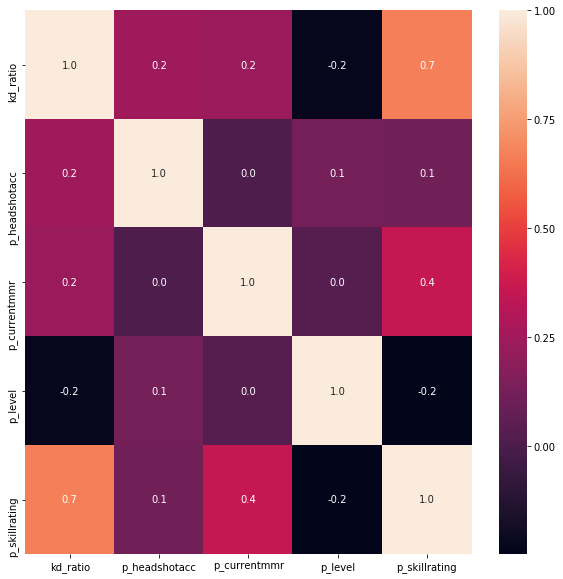

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.1f')
plt.show()

__*kd_ratio*__ has the highest correlation with __*p_skillrating*__ and __*p_currentmmr*__ is close behind.. 

However this is not enough to reject the null hypothesis that kd_ratio is not a stronger predictor of skillrating than currentmmr. I also include headshot accuracy into my models as R6tab stated that it is also a variable included in the calculation of their rating system.

Let's do some simple OLS regression tests

                            OLS Regression Results                            
Dep. Variable:          p_skillrating   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     240.1
Date:                Wed, 15 May 2019   Prob (F-statistic):           3.98e-40
Time:                        14:15:39   Log-Likelihood:                -2167.5
No. Observations:                 300   AIC:                             4339.
Df Residuals:                     298   BIC:                             4346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8714.0342     77.770    112.049      0.0

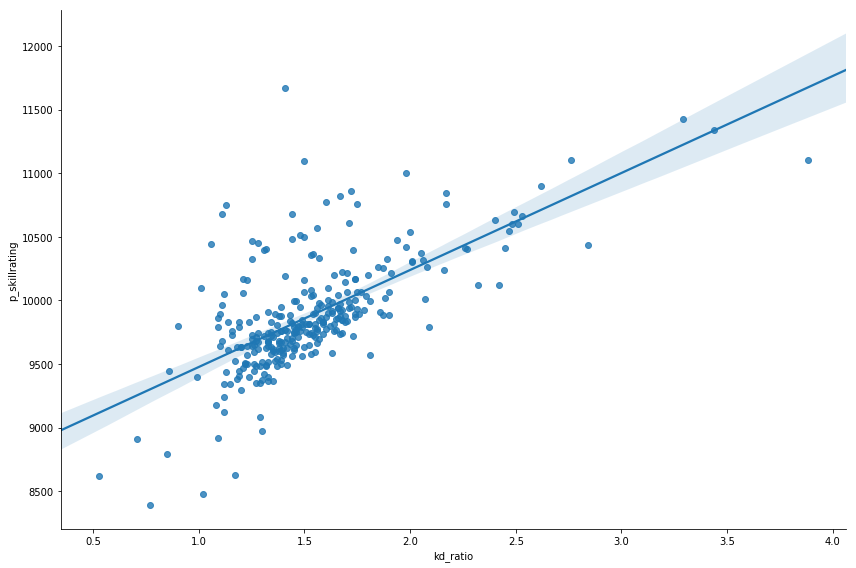

In [49]:
# kd_ratio on p_skillrating
query = """SELECT kd_ratio, p_skillrating FROM r6_leaderboard_database.focus"""
df = pd.read_sql(query, con=engine)

result = sm.ols(formula="p_skillrating ~ kd_ratio", data=df).fit()

print(result.summary())

sns.lmplot(x='kd_ratio', y='p_skillrating', data=df, height=8, aspect=1.5)
plt.show()

__Quick Summary:__ As predicted, kd_ratio is a significant predictor of p_skillrating. However, the standard error of the predictor is extremely high. Let's keep a note of this moving forward...



                            OLS Regression Results                            
Dep. Variable:          p_skillrating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.096
Date:                Wed, 15 May 2019   Prob (F-statistic):             0.0439
Time:                        14:29:58   Log-Likelihood:                -2254.1
No. Observations:                 300   AIC:                             4512.
Df Residuals:                     298   BIC:                             4520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9506.5096    187.081     50.815

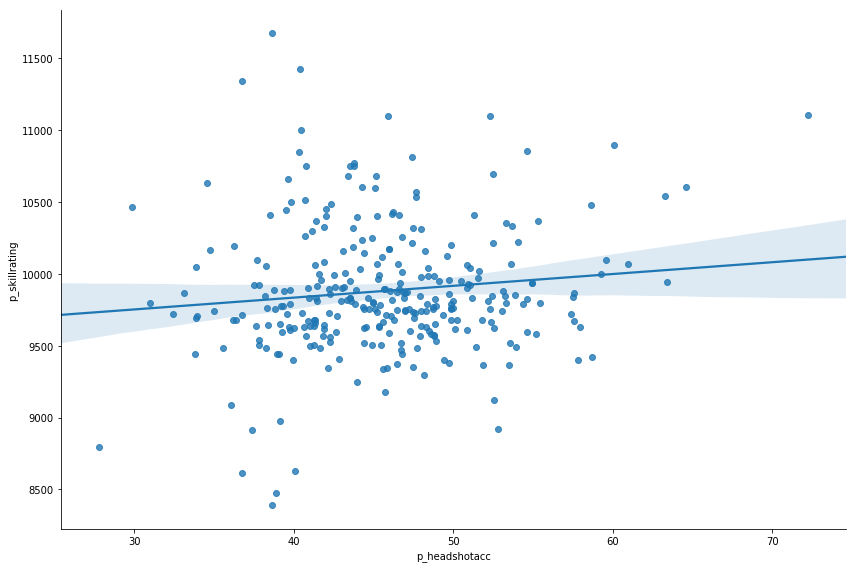

In [50]:
# p_headshotacc on p_skillrating

query = """SELECT p_headshotacc, p_skillrating FROM r6_leaderboard_database.focus"""
df = pd.read_sql(query, con=engine)

result = sm.ols(formula="p_skillrating ~ p_headshotacc", data=df).fit()

print(result.summary())

sns.lmplot(x='p_headshotacc', y='p_skillrating', data=df, height=8, aspect=1.5)
plt.show()

__Quick Summary:__ As expected from R6Tab's explanation of how they calculate their rating system, headshot accuracy is also a significant predictor, but much less so than k:d ratio. 

                            OLS Regression Results                            
Dep. Variable:          p_skillrating   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     44.18
Date:                Wed, 15 May 2019   Prob (F-statistic):           1.43e-10
Time:                        14:40:35   Log-Likelihood:                -2235.4
No. Observations:                 300   AIC:                             4475.
Df Residuals:                     298   BIC:                             4482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8135.1532    263.854     30.832   

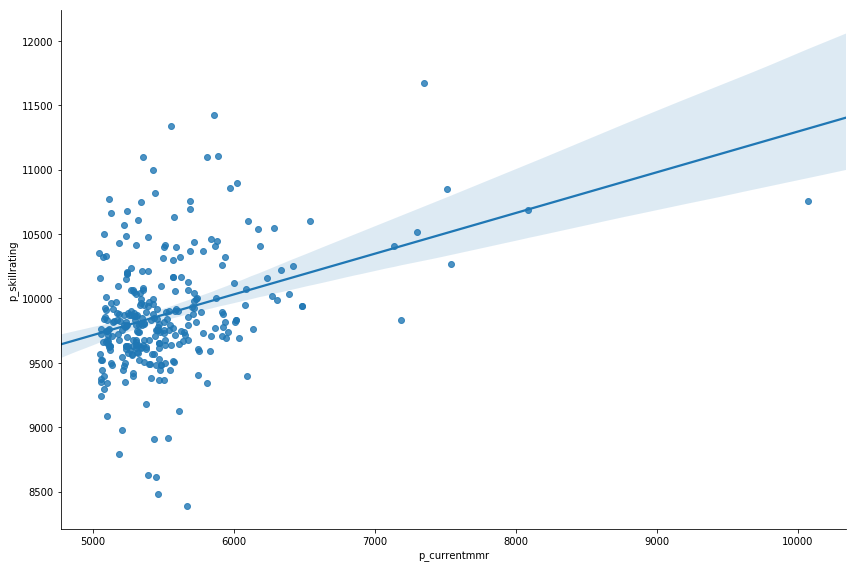

In [53]:
# p_currentmmr on p_skillrating

query = """SELECT p_currentmmr, p_skillrating FROM r6_leaderboard_database.focus"""
df = pd.read_sql(query, con=engine)

result = sm.ols(formula="p_skillrating ~ p_currentmmr", data=df).fit()

print(result.summary())

sns.lmplot(x='p_currentmmr', y='p_skillrating', data=df, height=8, aspect=1.5)
plt.show()

__Quick Summary:__ And Ubisoft's MMR system is also a significant predictor, with a very agreeable standard error. 

In [63]:
# Now for the main model: Multiple OLS Regression with all 3 variables of interest on p_skillrating

query = """SELECT kd_ratio, p_headshotacc, p_currentmmr, p_skillrating FROM r6_leaderboard_database.focus"""
df = pd.read_sql(query, con=engine)

result = sm.ols(formula="p_skillrating ~ kd_ratio + p_headshotacc + p_currentmmr", data=df).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          p_skillrating   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     95.18
Date:                Wed, 15 May 2019   Prob (F-statistic):           3.80e-43
Time:                        15:10:27   Log-Likelihood:                -2154.8
No. Observations:                 300   AIC:                             4318.
Df Residuals:                     296   BIC:                             4333.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7877.4931    241.417     32.630

## Conclusion of Results

The final regression model proves my hypothesis to be true: kd_ratio (_β=14.25, p_<.001) is a stronger significant predictor of R6Tab's skillrating than Ubisoft's MMR (_β =4.97, p <.001), F_(3, 296) = 95.18, *p*<.001. Headshot accuracy turned out to not be a significant predictor. 

There are two points to discuss, as mentioned by the model summary's 'Warning' tags at the end of each analysis. First, the standard errors are extremely high across the models. I expected this would be the case because of how small my sample size is, but also because of what my data is really about. The reason __*p_currentmmr*__ has a low and agreeable standard error is because the variable is a calculation of many variables such as games won and player skill differentials. Headshot accuracy and k:d ratio are individual variables and thus contain a larger standard error. Those two variables are not enough to precisely predict skill rating.

Second, multicollinearity might be present in my variables. Further analysis may reveal that there is high multicollinearity between kd_ratio and p_currentmmr

## Discussion

From one flawed system to the next. R6Tab's skill rating system may be considered an improvement over Ubisoft's for those that achieve a high amount of kills per death. However, individuals approach the game in a myriad of ways. I applaud R6Tab's attempt to improve an algorithm that attempts to capture a human condition. I personally would benefit from R6tab's system because I fall under the category of achieving a high K:D ratio. To improve R6Tab's formula, they would need to recalculate in a way such that k:d ratio does not have such a significant impact on skill rating, while also including more variables related to support playstyles (gadgets deployed, bombs defused, revives, etc). 

There is much more to tell from my analysis. I suggest for future study to first, pull a large sample size of Rainbow Six's playerbase. I acknowledge that my study had its limitations and biases by working with only the most extreme deviations of Ubisoft's MMR rankings (leaderboard data only). Second, I am a beginner data analyst, so I am aware that my methodology when approaching statistical analysis may have its errors. So to improve my regression models would require some ML methodology.


I would appreciate any advice anyone has for me. Your feedback is very important to me. 

## References

$^1$: https://rainbowsix.fandom.com/wiki/Ranked